# Proyek Klasifikasi Gambar: New Plant Diseases Dataset
- **Nama:** Laila Dwi Kartika Sari
- **Email:** e41220341@student.polije.ac.id
- **ID Dicoding:** lailadwikartikasari

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install -q kaggle

In [2]:
!pip install split-folders

In [3]:
!pip install tensorflow==2.18.0
!pip install tensorflow-decision-forests==1.11.0  # Versi sebelum 1.12.0
!pip install tf-keras==2.18.0  # Versi sebelum 2.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 52.9 MB/s eta 0:00:00


In [4]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


Melakukan import library yang digunakan untuk keseluruhan proyek.

In [5]:
import os  # Modul untuk berinteraksi dengan sistem operasi, seperti membaca dan menulis file
import splitfolders  # Digunakan untuk membagi dataset gambar ke dalam folder train, val, dan test secara otomatis
import tensorflow as tf  # Library utama untuk deep learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Modul untuk augmentasi dan preprocessing gambar
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten  # Lapisan-lapisan utama dalam CNN
from keras.models import Sequential  # Model sekuensial untuk membangun arsitektur CNN
from keras.preprocessing import image  # Modul untuk memuat dan memproses gambar individu
import matplotlib.pyplot as plt  # Modul untuk visualisasi data, seperti menampilkan gambar dan grafik
import numpy as np  # Library untuk operasi numerik, seperti manipulasi array
from PIL import Image  # Modul untuk membuka dan memproses gambar
import random  # Modul untuk operasi acak, seperti memilih gambar secara random
import shutil  # Modul untuk operasi file dan direktori, seperti menyalin atau memindahkan file
from tensorflow.keras.applications import MobileNetV2  # Model MobileNetV2 yang sudah dilatih sebelumnya, digunakan untuk transfer learning
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Callback untuk menyimpan model terbaik dan menghentikan pelatihan jika tidak ada peningkatan


Mengambil API Kaggle untuk mendapatkan dataset

In [8]:
# Menggunakan variabel lingkungan dengan aman
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

Melakukan cek version tensorflow

In [7]:
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.18.0


Dataset original bersumber dari [Kaggle](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset).

In [9]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors


Melakukan unzip terhadap file.

In [10]:
!unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

# Data Preparation

### Data Loading

Membuat fungsi untuk menampilkan jumlah gambar dari masing-masing kelas dan menghitung jumlah gambar dengan resolusi tertentu.

In [11]:
def count_images_and_resolution(base_path, target_resolution=None):
    # Dictionary untuk menyimpan jumlah gambar per kelas
    class_count = {}

    # Dictionary untuk menyimpan jumlah gambar per resolusi
    resolution_count = {}

    # Melakukan iterasi pada setiap folder dan file dalam base_path
    for root, dirs, files in os.walk(base_path):
        # Mengabaikan folder root utama karena tidak mewakili kelas tertentu
        if root == base_path:
            continue

        # Mengambil nama kelas dari nama folder
        class_name = os.path.basename(root)

        # Menyimpan jumlah gambar dalam kelas tersebut
        class_count[class_name] = len(files)

        # Iterasi melalui setiap file dalam folder kelas
        for file in files:
            file_path = os.path.join(root, file)  # Mendapatkan path lengkap file

            # Membuka gambar untuk mendapatkan resolusinya
            with Image.open(file_path) as img:
                width, height = img.size  # Mendapatkan ukuran gambar (lebar x tinggi)
                resolution = f"{width}x{height}"  # Format resolusi sebagai string (contoh: "256x256")

                # Jika resolusi belum ada dalam dictionary, inisialisasi dengan nilai 0
                if resolution not in resolution_count:
                    resolution_count[resolution] = 0

                # Menambahkan jumlah gambar dengan resolusi tersebut
                resolution_count[resolution] += 1

                # Jika ada resolusi target yang ingin dihitung secara spesifik
                if target_resolution and resolution == target_resolution:
                    if 'target' not in resolution_count:
                        resolution_count['target'] = 0
                    resolution_count['target'] += 1  # Menambahkan jumlah gambar dengan resolusi target

    return class_count, resolution_count  # Mengembalikan hasil dalam bentuk dictionary

# Path ke folder utama dataset
base_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

# Resolusi spesifik yang ingin dihitung jumlahnya
target_resolution = "256x256"

# Memanggil fungsi untuk menghitung jumlah gambar berdasarkan kelas dan resolusi
class_count, resolution_count = count_images_and_resolution(base_path, target_resolution)

# Menampilkan jumlah gambar per kelas
print("Jumlah gambar per kelas:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")

# Menampilkan jumlah gambar berdasarkan resolusi
print("\nJumlah gambar per resolusi:")
for resolution, count in resolution_count.items():
    print(f"{resolution}: {count}")

Jumlah gambar per kelas:
train: 0
Pepper,_bell___Bacterial_spot: 478
Soybean___healthy: 505
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 410
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 430
Potato___healthy: 456
Apple___Apple_scab: 504
Strawberry___healthy: 456
Tomato___Tomato_mosaic_virus: 448
Cherry_(including_sour)___Powdery_mildew: 421
Grape___Black_rot: 472
Potato___Late_blight: 485
Tomato___Leaf_Mold: 470
Squash___Powdery_mildew: 434
Pepper,_bell___healthy: 497
Corn_(maize)___Northern_Leaf_Blight: 477
Potato___Early_blight: 485
Apple___Cedar_apple_rust: 440
Strawberry___Leaf_scorch: 444
Corn_(maize)___Common_rust_: 477
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 490
Tomato___Late_blight: 463
Corn_(maize)___healthy: 465
Raspberry___healthy: 445
Peach___healthy: 432
Tomato___Target_Spot: 457
Tomato___healthy: 481
Cherry_(including_sour)___healthy: 456
Tomato___Septoria_leaf_spot: 436
Tomato___Bacterial_spot: 425
Orange___Haunglongbing_(Citrus_greening): 503
Tomato___Early_blight:

Terdapat 87867 gambar yang terbagi menjadi 38 kelas berbeda. Setiap gambar di masing-masing kelas memiliki resolusi 256x256.

Gambar diubah dengan resolusi antara 200 hingga 256. Gambar original akan ditimpa oleh gambar yang resolusi nya telah diubah sehingga tidak menambah jumlah dataset.

In [12]:
def resize_and_replace_images(base_path, min_res=200, max_res=256):
    # Iterasi melalui setiap folder dan file dalam base_path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            file_path = os.path.join(root, file)  # Mendapatkan path lengkap file

            try:
                # Membuka gambar
                with Image.open(file_path) as img:
                    # Menentukan ukuran baru secara acak dalam rentang yang diberikan
                    new_width = random.randint(min_res, max_res)
                    new_height = random.randint(min_res, max_res)

                    # Mengubah ukuran gambar sesuai ukuran baru
                    resized_img = img.resize((new_width, new_height))

                    # Jika gambar dalam mode RGBA tetapi disimpan sebagai JPEG, konversi ke RGB
                    if img.mode == "RGBA" and file_path.lower().endswith(".jpg"):
                        resized_img = resized_img.convert("RGB")

                    # Menyimpan gambar kembali ke lokasi yang sama (menggantikan gambar asli)
                    resized_img.save(file_path)

            except (IOError, OSError) as e:
                # Menangkap kesalahan yang terjadi saat membuka atau memproses gambar
                print(f"Error processing {file_path}: {e}")

# Path ke folder utama dataset
base_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

# Memanggil fungsi untuk mengubah ukuran dan mengganti gambar dalam dataset
resize_and_replace_images(base_path)

Menampilkan kembali jumlah gambar untuk masing-masing resolusi.

In [13]:
def count_images_and_resolution(base_path, target_resolution=None):
    class_count = {}  # Menyimpan jumlah gambar per kelas
    resolution_count = {}  # Menyimpan jumlah gambar per resolusi

    for root, dirs, files in os.walk(base_path):
        if root == base_path:  # Lewati folder root utama
            continue
        class_name = os.path.basename(root)
        class_count[class_name] = len(files)  # Hitung jumlah gambar per kelas

        for file in files:
            file_path = os.path.join(root, file)
            with Image.open(file_path) as img:
                width, height = img.size
                resolution = f"{width}x{height}"

                if resolution not in resolution_count:
                    resolution_count[resolution] = 0  # Inisialisasi jika belum ada

                resolution_count[resolution] += 1  # Tambah jumlah gambar dengan resolusi tersebut

                if target_resolution and resolution == target_resolution:
                    if 'target' not in resolution_count:
                        resolution_count['target'] = 0
                    resolution_count['target'] += 1  # Hitung gambar dengan resolusi target

    return class_count, resolution_count  # Kembalikan hasil perhitungan

# Path ke folder utama dataset
base_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

# Resolusi yang ingin dihitung
target_resolution = "256x256"

class_count, resolution_count = count_images_and_resolution(base_path, target_resolution)

print("\nJumlah gambar per resolusi:")
for resolution, count in resolution_count.items():
    print(f"{resolution}: {count}")  # Cetak jumlah gambar per resolusi



Jumlah gambar per resolusi:
235x214: 33
202x225: 31
220x210: 30
206x217: 28
206x204: 24
215x240: 27
236x203: 18
218x209: 28
221x201: 34
251x216: 29
226x207: 25
219x212: 36
236x255: 29
213x249: 23
200x239: 26
232x209: 19
245x200: 24
230x212: 30
205x237: 26
238x209: 21
216x247: 25
233x213: 23
210x227: 26
220x238: 25
217x242: 27
251x214: 23
208x220: 24
244x253: 33
249x243: 25
220x228: 36
227x221: 31
212x244: 36
202x223: 34
222x210: 25
216x241: 26
240x208: 26
235x233: 32
227x231: 29
237x241: 31
254x222: 22
246x205: 23
232x213: 34
224x202: 22
235x210: 36
226x226: 29
242x242: 25
245x215: 32
256x223: 28
243x219: 20
220x213: 35
245x210: 30
208x216: 18
244x247: 26
205x243: 21
240x243: 25
209x251: 26
241x230: 34
256x238: 27
246x224: 25
223x206: 25
231x210: 30
236x230: 32
210x208: 26
239x255: 28
236x243: 33
214x251: 30
211x209: 22
235x250: 30
228x244: 30
214x241: 26
237x236: 30
255x200: 35
254x215: 31
235x253: 32
200x248: 30
200x233: 35
233x239: 18
207x242: 34
206x229: 27
239x240: 27
256x218: 26

### Data Preprocessing

Secara total terdapat 38 jenis tanaman yang berbeda. Namun pada proyek kali ini akan fokus ke tanaman tomat karena jumlah gambar lebih dari 10.000

In [14]:
def count_images(base_path, target_classes=["Tomato"]):
    total_count = 0  # Inisialisasi total jumlah gambar
    class_counts = {cls: 0 for cls in target_classes}  # Inisialisasi jumlah gambar per kelas target

    for root, dirs, files in os.walk(base_path):
        total_count += len(files)  # Tambahkan jumlah gambar di setiap folder
        for cls in target_classes:
            if cls.lower() in root.lower():  # Periksa apakah nama kelas ada di path folder
                class_counts[cls] += len(files)  # Tambahkan jumlah gambar ke kelas yang sesuai

    return total_count, class_counts  # Kembalikan total gambar dan jumlah per kelas target

# Path ke folder utama dataset
base_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

# Hitung jumlah gambar dalam dataset
total_count, class_counts = count_images(base_path)

# Tampilkan hasil perhitungan
print(f"Jumlah total gambar dalam dataset: {total_count}")
for cls, count in class_counts.items():
    print(f"Jumlah gambar dalam kelas '{cls}': {count}")  # Cetak jumlah gambar per kelas target


Jumlah total gambar dalam dataset: 87867
Jumlah gambar dalam kelas 'Tomato': 22930


Menampilkan jumlah gambar untuk masing-masing subkelas dari tanaman tomat.

In [15]:
def count_tomato_images_per_subclass(base_path, target_class="Tomato"):
    class_count = {}  # Inisialisasi dictionary untuk menyimpan jumlah gambar per subkelas

    for root, dirs, files in os.walk(base_path):
        if target_class.lower() in root.lower():  # Cek apakah folder mengandung nama kelas target
            subclass_name = os.path.basename(root)  # Ambil nama subkelas dari folder
            if subclass_name not in class_count:
                class_count[subclass_name] = 0  # Inisialisasi jika belum ada
            class_count[subclass_name] += len(files)  # Tambahkan jumlah gambar dalam subkelas

    return class_count  # Kembalikan jumlah gambar per subkelas

# Path ke folder utama dataset
base_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

# Hitung jumlah gambar untuk subkelas dalam kelas "Tomato"
tomato_class_count = count_tomato_images_per_subclass(base_path)

# Menampilkan hasil
print("Jumlah gambar Tomato dari masing-masing subkelas:")
for subclass, count in tomato_class_count.items():
    print(f"{subclass}: {count}")  # Cetak jumlah gambar per subkelas


Jumlah gambar Tomato dari masing-masing subkelas:
Tomato___Tomato_mosaic_virus: 2238
Tomato___Leaf_Mold: 2352
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 2451
Tomato___Late_blight: 2314
Tomato___Target_Spot: 2284
Tomato___healthy: 2407
Tomato___Septoria_leaf_spot: 2181
Tomato___Bacterial_spot: 2127
Tomato___Early_blight: 2400
Tomato___Spider_mites Two-spotted_spider_mite: 2176


Memindahkan folder tanaman tomat dari /New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented) ke /Tomato

In [16]:
def copy_tomato_folders(base_path, target_folder="Tomato", target_class="tomato"):
    if not os.path.exists(target_folder):  # Periksa apakah folder tujuan sudah ada
        os.makedirs(target_folder)  # Buat folder tujuan jika belum ada

    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            if target_class.lower() in dir_name.lower():  # Cek apakah folder mengandung nama "tomato"
                source_path = os.path.join(root, dir_name)  # Path folder sumber
                dest_path = os.path.join(target_folder, dir_name)  # Path folder tujuan
                if not os.path.exists(dest_path):  # Cek apakah folder tujuan sudah ada
                    shutil.copytree(source_path, dest_path)  # Salin seluruh folder
                    print(f"Menyalin {source_path} ke {dest_path}")  # Cetak status penyalinan

# Path ke folder utama dataset
base_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

# Path ke folder tujuan untuk menyimpan data Tomato
target_folder = "/content/Tomato"

# Menyalin folder yang mengandung "Tomato"
copy_tomato_folders(base_path, target_folder)


Menyalin /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Tomato_mosaic_virus ke /content/Tomato/Tomato___Tomato_mosaic_virus
Menyalin /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Leaf_Mold ke /content/Tomato/Tomato___Leaf_Mold
Menyalin /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus ke /content/Tomato/Tomato___Tomato_Yellow_Leaf_Curl_Virus
Menyalin /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Late_blight ke /content/Tomato/Tomato___Late_blight
Menyalin /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Target_Spot ke /content/Tomato/Tomato___Target_Spot
Menyalin /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy ke /content/Tomato/Tomato___he

Menghapus nama file"tomato___".

In [17]:
def rename_folders(base_path, prefix="Tomato___"):
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            if dir_name.startswith(prefix):  # Periksa apakah nama folder dimulai dengan prefix
                new_dir_name = dir_name[len(prefix):]  # Hapus prefix dari nama folder
                old_path = os.path.join(root, dir_name)  # Path lama folder
                new_path = os.path.join(root, new_dir_name)  # Path baru tanpa prefix
                os.rename(old_path, new_path)  # Ganti nama folder
                print(f"Renamed {old_path} to {new_path}")  # Cetak status perubahan

# Path ke folder utama yang berisi folder Tomato
base_path = "/content/Tomato"

# Jalankan fungsi untuk mengganti nama folder
rename_folders(base_path)


Renamed /content/Tomato/Tomato___Tomato_mosaic_virus to /content/Tomato/Tomato_mosaic_virus
Renamed /content/Tomato/Tomato___Leaf_Mold to /content/Tomato/Leaf_Mold
Renamed /content/Tomato/Tomato___Tomato_Yellow_Leaf_Curl_Virus to /content/Tomato/Tomato_Yellow_Leaf_Curl_Virus
Renamed /content/Tomato/Tomato___Late_blight to /content/Tomato/Late_blight
Renamed /content/Tomato/Tomato___Target_Spot to /content/Tomato/Target_Spot
Renamed /content/Tomato/Tomato___healthy to /content/Tomato/healthy
Renamed /content/Tomato/Tomato___Septoria_leaf_spot to /content/Tomato/Septoria_leaf_spot
Renamed /content/Tomato/Tomato___Bacterial_spot to /content/Tomato/Bacterial_spot
Renamed /content/Tomato/Tomato___Early_blight to /content/Tomato/Early_blight
Renamed /content/Tomato/Tomato___Spider_mites Two-spotted_spider_mite to /content/Tomato/Spider_mites Two-spotted_spider_mite


Menampilkan contoh gambar dari masing-masing kelas tomat.

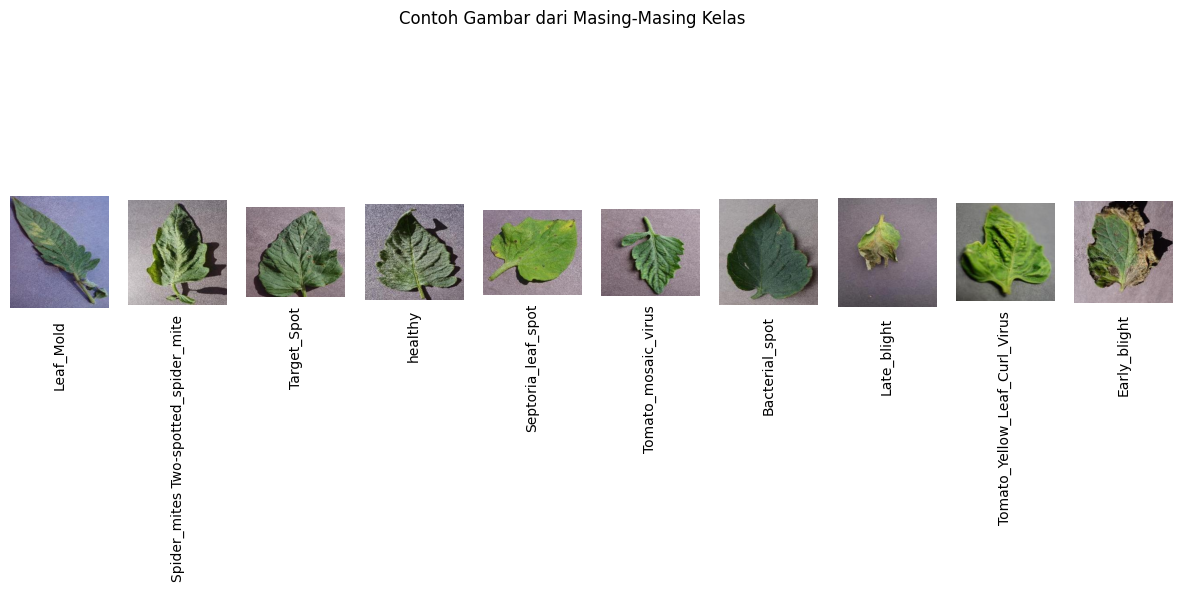

In [18]:
def show_example_images(base_path):
    class_images = {}  # Dictionary untuk menyimpan contoh gambar per kelas

    for root, dirs, files in os.walk(base_path):
        if files:  # Periksa apakah folder memiliki file gambar
            class_name = os.path.basename(root)  # Ambil nama kelas dari folder
            random_image = random.choice(files)  # Pilih satu gambar secara acak
            class_images[class_name] = os.path.join(root, random_image)  # Simpan path gambar

    fig, axes = plt.subplots(1, len(class_images), figsize=(15, 5))  # Buat subplot dengan jumlah kelas
    fig.suptitle('Contoh Gambar dari Masing-Masing Kelas')  # Judul grafik

    for ax, (class_name, image_path) in zip(axes, class_images.items()):
        img = Image.open(image_path)  # Buka gambar
        ax.imshow(img)  # Tampilkan gambar
        ax.text(0.5, -0.1, class_name, rotation=90, verticalalignment='top', horizontalalignment='center', transform=ax.transAxes)  # Tambahkan label kelas
        ax.axis('off')  # Sembunyikan axis

    plt.show()  # Tampilkan plot

# Path ke folder utama yang berisi dataset
base_path = "/content/Tomato"

# Jalankan fungsi untuk menampilkan contoh gambar
show_example_images(base_path)


#### Split Dataset

Pada proyek dicoding jumlah dataset minimal yang dibutuhkan adalah 10.000 sehingga pada proyek kali ini hanya akan dipilih 5 kelas saja dari tanaman tomat agar meringangkan beban kerja. Kelas yang dipilih dan jumlah akhir dari dataset adalah sebagai berikut:

- healthy: 2407
- Spider_mites Two-spotted_spider_mite: 2176
- Late_blight: 2314
- Tomato_Yellow_Leaf_Curl_Virus: 2451
- Septoria_leaf_spot: 2181

- Total = 11529 gambar

Menghapus semua folder kecuali folder yang akan digunakan.

In [19]:
def delete_unwanted_folders(base_path, keep_folders=['healthy', 'Spider_mites Two-spotted_spider_mite',
                                                     'Late_blight', 'Tomato_Yellow_Leaf_Curl_Virus',
                                                     'Septoria_leaf_spot']):
    for item in os.listdir(base_path):  # Iterasi semua item di dalam folder utama
        item_path = os.path.join(base_path, item)  # Buat path lengkap ke item
        if os.path.isdir(item_path) and item not in keep_folders:  # Jika item adalah folder dan bukan yang ingin disimpan
            shutil.rmtree(item_path)  # Hapus folder beserta isinya
            print(f"Menghapus folder: {item_path}")  # Tampilkan folder yang dihapus

# Path ke folder utama yang berisi dataset
base_path = "/content/Tomato"

# Jalankan fungsi untuk menghapus folder yang tidak diinginkan
delete_unwanted_folders(base_path)


Menghapus folder: /content/Tomato/Leaf_Mold
Menghapus folder: /content/Tomato/Target_Spot
Menghapus folder: /content/Tomato/Tomato_mosaic_virus
Menghapus folder: /content/Tomato/Bacterial_spot
Menghapus folder: /content/Tomato/Early_blight


Membagi dataset menjadi train dan test dengan rasio 8:2.

In [20]:
def split_dataset(base_path, train_ratio=0.8):
    # Path untuk dataset pelatihan dan pengujian
    train_path = os.path.join(base_path, 'train')  # Folder train
    test_path = os.path.join(base_path, 'test')  # Folder test

    # Membuat folder train dan test jika belum ada
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for root, dirs, files in os.walk(base_path):  # Iterasi melalui semua folder dalam dataset
        if root == base_path:  # Lewati folder utama
            continue

        class_name = os.path.basename(root)  # Ambil nama kelas dari folder
        if class_name in ['train', 'test']:  # Lewati folder train dan test jika sudah ada
            continue

        # Buat folder untuk kelas di dalam train dan test
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Acak urutan file sebelum dibagi
        random.shuffle(files)
        split_index = int(train_ratio * len(files))  # Hitung jumlah file untuk train
        train_files = files[:split_index]  # Ambil bagian untuk train
        test_files = files[split_index:]  # Sisanya untuk test

        # Pindahkan file ke folder train
        for file in train_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(train_class_path, file)
            shutil.move(src_file, dst_file)  # Pindahkan file

        # Pindahkan file ke folder test
        for file in test_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(test_class_path, file)
            shutil.move(src_file, dst_file)  # Pindahkan file

# Path ke folder utama yang berisi dataset
base_path = "/content/Tomato"

# Jalankan fungsi untuk membagi dataset menjadi train dan test
split_dataset(base_path)


Menghapus folder selain folder train dan test.

In [21]:
def delete_unwanted_folders(base_path, keep_folders=['train', 'test']):
    for item in os.listdir(base_path):  # Iterasi semua item dalam folder utama
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item not in keep_folders:  # Hapus jika bukan folder yang dipertahankan
            shutil.rmtree(item_path)  # Hapus folder beserta isinya
            print(f"Menghapus folder: {item_path}")  # Menampilkan folder yang dihapus

# Path ke folder utama
base_path = "/content/Tomato"

# Jalankan fungsi untuk menghapus folder yang tidak diperlukan
delete_unwanted_folders(base_path)


Menghapus folder: /content/Tomato/Spider_mites Two-spotted_spider_mite
Menghapus folder: /content/Tomato/healthy
Menghapus folder: /content/Tomato/Septoria_leaf_spot
Menghapus folder: /content/Tomato/Late_blight
Menghapus folder: /content/Tomato/Tomato_Yellow_Leaf_Curl_Virus


## Modelling

Menggunakan ImageDataGenerator untuk melakukan augmentasi, rescale, dan mengubah target size.

Dataset test hanya akan dilakukan rescale.

In [22]:
def augment_and_resize_dataset(base_path, img_size=(150, 150), batch_size=32):
    train_path = os.path.join(base_path, 'train')  # Path ke folder train
    test_path = os.path.join(base_path, 'test')  # Path ke folder test

    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalisasi nilai piksel ke [0,1]
        zoom_range=0.2,  # Zooming acak hingga 20%
        horizontal_flip=True,  # Membalik gambar secara horizontal
        fill_mode='nearest'  # Mengisi piksel kosong akibat transformasi
    )

    test_datagen = ImageDataGenerator(rescale=1./255)  # Hanya normalisasi untuk data uji

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,  # Ubah ukuran gambar ke target
        batch_size=batch_size,  # Ukuran batch dalam pelatihan
        class_mode='categorical'  # Klasifikasi multi-kelas
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, test_generator  # Mengembalikan generator untuk train & test

# Path ke folder utama
base_path = "/content/Tomato"

# Jalankan fungsi augmentasi dan resize dataset
train_generator, test_generator = augment_and_resize_dataset(base_path)


Found 7258 images belonging to 5 classes.
Found 1966 images belonging to 5 classes.


Menampilkan kelas-kelas yang terdapat pada dataset.

In [23]:
class_indices = train_generator.class_indices  # Mendapatkan indeks kelas
print(class_indices)  # Menampilkan mapping kelas ke indeks

{'Late_blight': 0, 'Septoria_leaf_spot': 1, 'Spider_mites Two-spotted_spider_mite': 2, 'Tomato_Yellow_Leaf_Curl_Virus': 3, 'healthy': 4}


Menggunakan transferlearning dari MobileNetV2. Input shape yang digunakan adalah 150x150, layers di freeze agar tidak dilatih kembali, dan menambahkan beberapa layer Conv dan Pooling.

In [25]:
# Menggunakan MobileNetV2 sebagai feature extractor tanpa fully connected layer (include_top=False)
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150,150,3))

# Membekukan semua layer MobileNetV2 agar tidak dilatih ulang
for layer in pre_trained_model.layers:
    layer.trainable = False

# Membuat model Sequential
model = Sequential()

# Menambahkan MobileNetV2 sebagai base model
model.add(pre_trained_model)

# Menambahkan lapisan tambahan untuk ekstraksi fitur lebih lanjut
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))  # Layer konvolusi dengan 32 filter
model.add(MaxPooling2D((2, 2)))  # Pooling untuk mengurangi dimensi fitur
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  # Layer konvolusi dengan 64 filter
model.add(MaxPooling2D((2, 2)))  # Pooling kembali untuk mengurangi dimensi fitur

# Meratakan fitur menjadi vektor 1D
model.add(Flatten(name="flatten"))

# Dropout untuk mengurangi overfitting
model.add(Dropout(0.5))

# Fully connected layer dengan 128 unit
model.add(Dense(128, activation="relu"))

# Output layer dengan 5 unit (jumlah kelas) dan aktivasi softmax untuk klasifikasi multi-kelas
model.add(Dense(5, activation='softmax'))

<ipython-input-25-9c7e0efd192c>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150,150,3))


Mengcompile model dengan optimizer Adam, loss categorical_crossentropy, dan metrics accuracy.

In [26]:
# Menggunakan optimizer Adam untuk mempercepat konvergensi
optimizer = tf.optimizers.Adam()

# Kompilasi model dengan loss categorical_crossentropy (karena klasifikasi multi-kelas)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # Digunakan untuk klasifikasi multi-kelas
              metrics=['accuracy'])  # Menggunakan metrik akurasi untuk evaluasi performa


Membuat callbacks yang memonitor val_accuracy dan akan berhenti jika tidak mengalami perubahan selama 3 epochs.

In [27]:
# Menyimpan model terbaik berdasarkan nilai val_loss yang paling kecil
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Menghentikan pelatihan lebih awal jika val_accuracy tidak meningkat dalam 3 epoch berturut-turut
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001,
                               restore_best_weights=True, mode='max', baseline=0.96)


Melatih model selama 15 epoch dan menggunakan data test sebagai validation.

In [28]:
num_epochs = 15  # Jumlah epoch pelatihan

H = model.fit(
    train_generator,   # Data latih yang telah diaugmentasi
    epochs=num_epochs, # Jumlah epoch yang ditentukan (15)
    validation_data=test_generator  # Data validasi untuk mengevaluasi model
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 225s 962ms/step - accuracy: 0.5988 - loss: 1.0567 - val_accuracy: 0.9003 - val_loss: 0.3147
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 255s 935ms/step - accuracy: 0.9170 - loss: 0.2653 - val_accuracy: 0.9303 - val_loss: 0.2041
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 269s 958ms/step - accuracy: 0.9297 - loss: 0.2209 - val_accuracy: 0.9201 - val_loss: 0.2626
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 194s 853ms/step - accuracy: 0.9488 - loss: 0.1595 - val_accuracy: 0.9329 - val_loss: 0.2067
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 201s 850ms/step - accuracy: 0.9547 - loss: 0.1484 - val_accuracy: 0.9446 - val_loss: 0.2069
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 192s 846ms/step - accuracy: 0.9616 - loss: 0.1195 - val_accuracy: 0.9481 - val_loss: 0.1521
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 192s 846ms/step - accuracy: 0.9645 - loss: 0.1218 - val_accuracy: 0.9512 - val_loss: 0.1450
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 218s 916ms/step - accuracy: 0.9690 -

## Evaluasi dan Visualisasi

Menampilkan grafik train dan val akurasi serta train dan val loss.

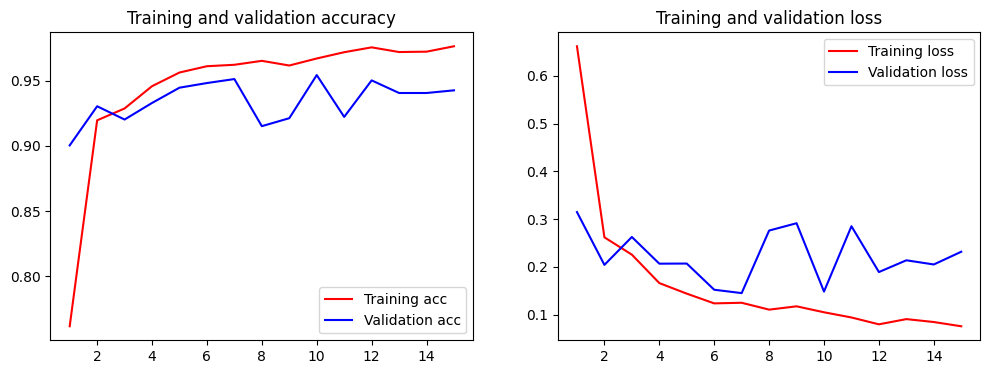

In [29]:
def plot_training_history(history):
    # Mengambil data akurasi dan loss dari hasil training
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)  # Menentukan jumlah epoch

    plt.figure(figsize=(12, 4))  # Mengatur ukuran figure

    # Plot untuk Training & Validation Accuracy
    plt.subplot(1, 2, 1)  # Membuat subplot pertama
    plt.plot(epochs, acc, 'r', label='Training acc')  # Plot akurasi training
    plt.plot(epochs, val_acc, 'b', label='Validation acc')  # Plot akurasi validasi
    plt.title('Training and validation accuracy')  # Judul plot
    plt.legend()  # Menampilkan legenda

    # Plot untuk Training & Validation Loss
    plt.subplot(1, 2, 2)  # Membuat subplot kedua
    plt.plot(epochs, loss, 'r', label='Training loss')  # Plot loss training
    plt.plot(epochs, val_loss, 'b', label='Validation loss')  # Plot loss validasi
    plt.title('Training and validation loss')  # Judul plot
    plt.legend()  # Menampilkan legenda

    plt.show()  # Menampilkan plot

# Memanggil fungsi untuk menampilkan grafik hasil training
plot_training_history(H)

## Konversi Model

Menyimpan model menjadi format .h5.

In [34]:
model.save("model.h5")

# Konversi TFJS

Konversi model menjadi format TFJS.

In [35]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-03-21 15:21:58.298121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742570518.322648   29430 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742570518.329766   29430 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


# Konversi SavedModel

Konversi menjadi saved_model.

In [36]:
# Menentukan path tempat model akan disimpan
save_path = os.path.join("model/klasifikasi_gambar/1/")

# Menyimpan model dalam format TensorFlow SavedModel
tf.saved_model.save(model, save_path)  # Format ini digunakan untuk TensorFlow Serving atau deployment

# Konversi TF-Lite

Konversi model menjadi format TFLITE dan menyimpan label.txt.

In [37]:
# Memuat model Keras yang telah disimpan dalam format .h5
model_TFLITE = tf.keras.models.load_model('model.h5')

# Mengonversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_TFLITE)  # Membuat konverter dari model Keras
tflite_model = converter.convert()  # Mengubah model ke format TFLite

# Menyimpan model yang telah dikonversi ke dalam file .tflite
with open("converted_model.tflite", "wb") as f:
    f.write(tflite_model)  # Menyimpan model dalam bentuk biner ke file

Saved artifact at '/tmp/tmpvlp5_sn0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136099760421776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099760420432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099760420048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099760420240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099760421584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099760418896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099760418512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099760418128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099760418320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099760421008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1360997604169

In [38]:
# Buat konten yang akan ditulis ke dalam file
content = """healthy
Spider_mites Two-spotted_spider_mite
Late_blight
Tomato_Yellow_Leaf_Curl_Virus
Septoria_leaf_spot"""

# Tentukan path dan nama file untuk menyimpan label klasifikasi
file_path = "/content/model/klasifikasi_gambar.txt"

# Tulis konten ke dalam file
with open(file_path, "w") as file:
    file.write(content)  # Menulis label klasifikasi ke dalam file

In [39]:
# Tentukan folder yang akan dikompresi
folder_models = '/content/model'
folder_tfjs_model = '/content/tfjs_model'

# Tentukan nama file output ZIP (tanpa ekstensi .zip)
output_models = '/content/model'  # Hasilnya akan menjadi models.zip
output_tfjs_model = '/content/tfjs_model'  # Hasilnya akan menjadi tfjs_model.zip

# Mengompresi folder menjadi file ZIP
shutil.make_archive(output_models, 'zip', folder_models)  # Membuat models.zip
shutil.make_archive(output_tfjs_model, 'zip', folder_tfjs_model)  # Membuat tfjs_model.zip

'/content/tfjs_model.zip'

In [40]:
!pip freeze > requirements.txt

## Inference (Optional)